In [1]:
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import torch
from dataset import OcelotSpaceChargeQuadrupoleDataset
from models import SupervisedSpaceChargeQuadrupoleInference
from ocelot.adaptors.astra2ocelot import astraBeam2particleArray

/opt/homebrew/Caskroom/miniforge/base/envs/cheetah-demos/lib/python3.9/site-packages/ocelot/cpbd/beam.py:1567: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  slice_analysis = slice_analysis_py if not nb_flag else nb.jit(slice_analysis_py)
/opt/homebrew/Caskroom/miniforge/base/envs/cheetah-demos/lib/python3.9/site-packages/ocelot/cpbd/tm_utils.py:153: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behavi

initializing ocelot...
import: module PYFFTW is not installed. Install it to speed up calculation


/opt/homebrew/Caskroom/miniforge/base/envs/cheetah-demos/lib/python3.9/site-packages/ocelot/cpbd/wake3D.py:80: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  project_on_grid = project_on_grid_py if not nb_flag else nb.jit(project_on_grid_py)


In [2]:
dataset_train = OcelotSpaceChargeQuadrupoleDataset(
    stage="train", use_logarithm=True, normalize=True
)

In [3]:
dataset_train_raw = OcelotSpaceChargeQuadrupoleDataset(
    stage="train", use_logarithm=False, normalize=False
)
dataset_test_raw = OcelotSpaceChargeQuadrupoleDataset(
    stage="test", use_logarithm=False, normalize=False
)

In [4]:
model = SupervisedSpaceChargeQuadrupoleInference.load_from_checkpoint(
    "space-charge-quadrupole/ghpd58x1/checkpoints/epoch=32-step=123750.ckpt"
)
model.cpu().eval()

SupervisedSpaceChargeQuadrupoleInference(
  (net): SpaceChargeQuadrupoleMLP(
    (input_layer): Sequential(
      (0): Linear(in_features=10, out_features=512, bias=True)
      (1): Identity()
      (2): Tanh()
    )
    (hidden_net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=512, out_features=512, bias=True)
        (1): Identity()
        (2): Tanh()
      )
      (1): Sequential(
        (0): Linear(in_features=512, out_features=512, bias=True)
        (1): Identity()
        (2): Tanh()
      )
      (2): Sequential(
        (0): Linear(in_features=512, out_features=512, bias=True)
        (1): Identity()
        (2): Tanh()
      )
    )
    (output_layer): Linear(in_features=512, out_features=6, bias=True)
  )
  (criterion): MSELoss()
)

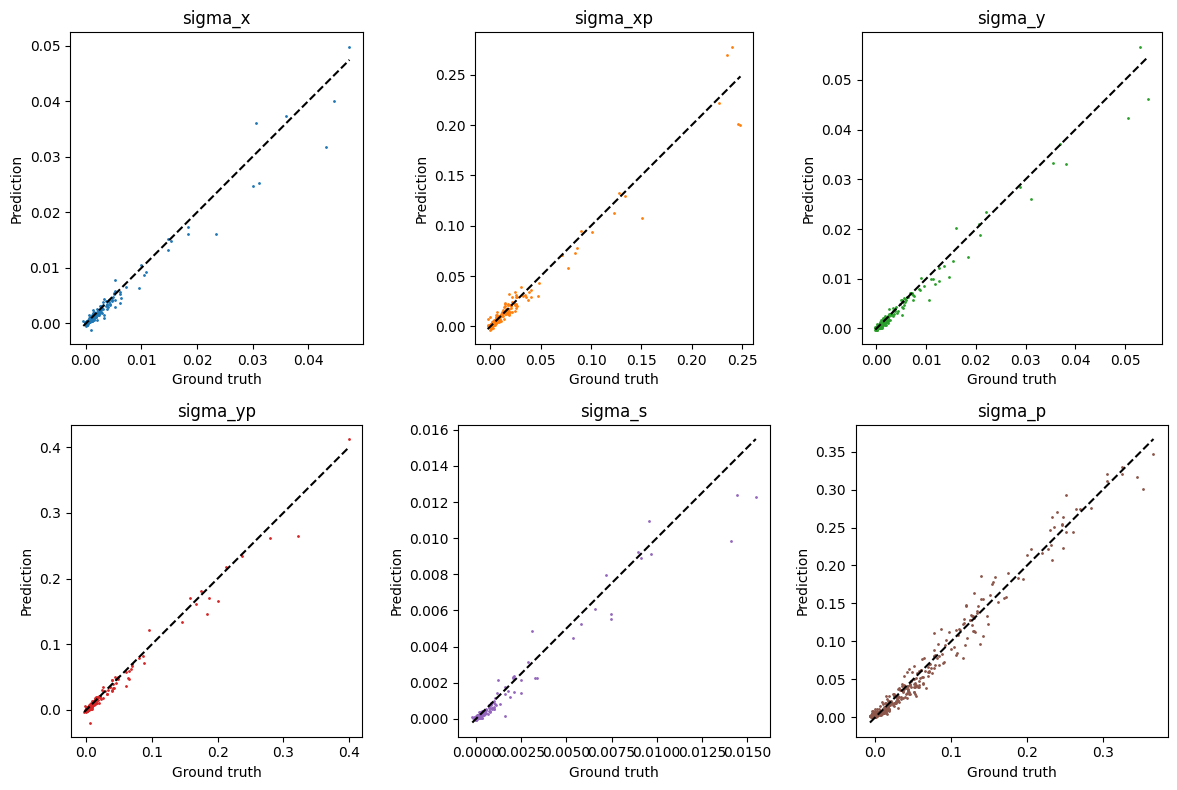

In [5]:
num_samples = 1_000

ground_truth = np.array([dataset_train_raw[i][1] for i in range(num_samples)])

incoming_batch_raw = np.stack([dataset_train_raw[i][0][0] for i in range(num_samples)])
controls_batch_raw = np.stack([dataset_train_raw[i][0][1] for i in range(num_samples)])

incoming_batch = torch.from_numpy(
    dataset_train.incoming_scaler.transform(np.log(incoming_batch_raw))
).float()
controls_batch = torch.from_numpy(
    dataset_train.controls_scaler.transform(controls_batch_raw)
).float()

predictions_raw = model(incoming_batch, controls_batch).detach().numpy()

predictions = dataset_train.outgoing_delta_scaler.inverse_transform(predictions_raw)

plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.scatter(ground_truth[:, 0], predictions[:, 0], s=1, c="tab:blue")
plt.plot(
    [ground_truth[:, 0].min(), ground_truth[:, 0].max()],
    [ground_truth[:, 0].min(), ground_truth[:, 0].max()],
    c="k",
    ls="--",
)
plt.xlabel("Ground truth")
plt.ylabel("Prediction")
plt.title("sigma_x")
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(2, 3, 2)
plt.scatter(ground_truth[:, 1], predictions[:, 1], s=1, c="tab:orange")
plt.plot(
    [ground_truth[:, 1].min(), ground_truth[:, 1].max()],
    [ground_truth[:, 1].min(), ground_truth[:, 1].max()],
    c="k",
    ls="--",
)
plt.xlabel("Ground truth")
plt.ylabel("Prediction")
plt.title("sigma_xp")
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(2, 3, 3)
plt.scatter(ground_truth[:, 2], predictions[:, 2], s=1, c="tab:green")
plt.plot(
    [ground_truth[:, 2].min(), ground_truth[:, 2].max()],
    [ground_truth[:, 2].min(), ground_truth[:, 2].max()],
    c="k",
    ls="--",
)
plt.xlabel("Ground truth")
plt.ylabel("Prediction")
plt.title("sigma_y")
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(2, 3, 4)
plt.scatter(ground_truth[:, 3], predictions[:, 3], s=1, c="tab:red")
plt.plot(
    [ground_truth[:, 3].min(), ground_truth[:, 3].max()],
    [ground_truth[:, 3].min(), ground_truth[:, 3].max()],
    c="k",
    ls="--",
)
plt.xlabel("Ground truth")
plt.ylabel("Prediction")
plt.title("sigma_yp")
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(2, 3, 5)
plt.scatter(ground_truth[:, 4], predictions[:, 4], s=1, c="tab:purple")
plt.plot(
    [ground_truth[:, 4].min(), ground_truth[:, 4].max()],
    [ground_truth[:, 4].min(), ground_truth[:, 4].max()],
    c="k",
    ls="--",
)
plt.xlabel("Ground truth")
plt.ylabel("Prediction")
plt.title("sigma_s")
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(2, 3, 6)
plt.scatter(ground_truth[:, 5], predictions[:, 5], s=1, c="tab:brown")
plt.plot(
    [ground_truth[:, 5].min(), ground_truth[:, 5].max()],
    [ground_truth[:, 5].min(), ground_truth[:, 5].max()],
    c="k",
    ls="--",
)
plt.xlabel("Ground truth")
plt.ylabel("Prediction")
plt.title("sigma_p")
plt.gca().set_aspect("equal", adjustable="box")

plt.tight_layout()
plt.show()

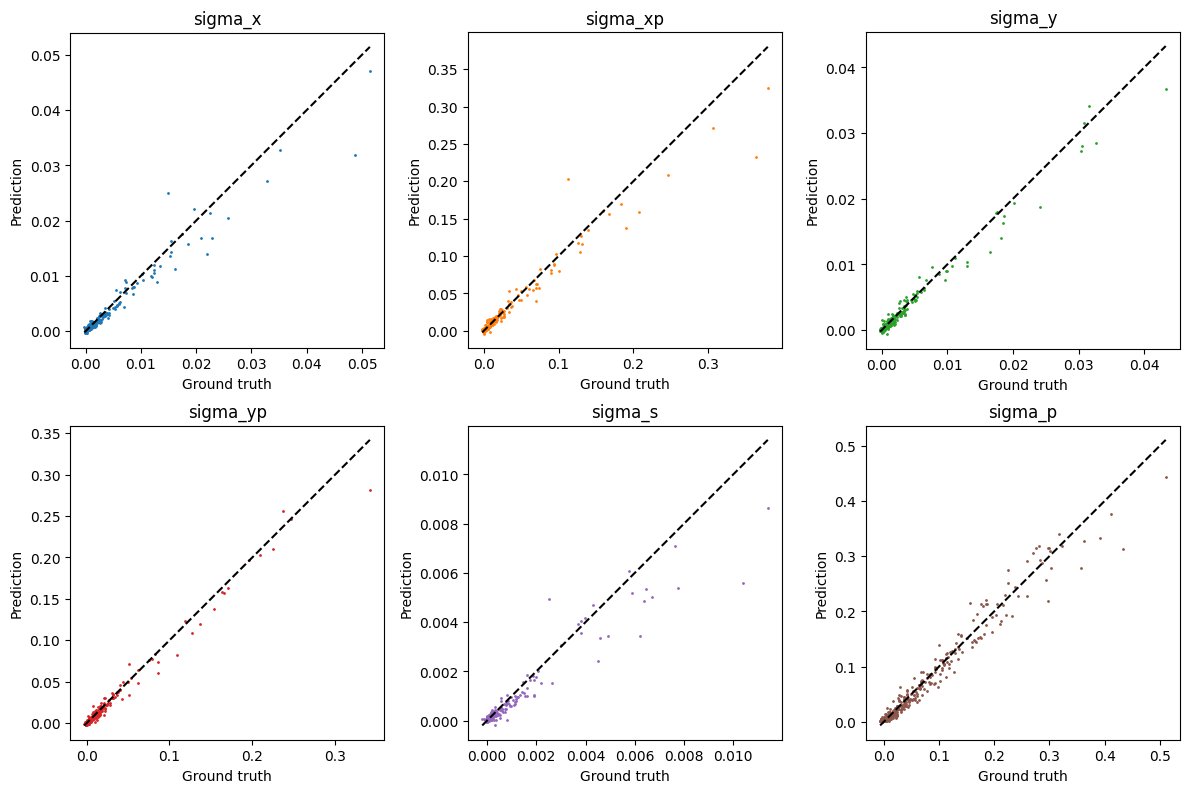

In [6]:
num_samples = 1_000

ground_truth = np.array([dataset_test_raw[i][1] for i in range(num_samples)])

incoming_batch_raw = np.stack([dataset_test_raw[i][0][0] for i in range(num_samples)])
controls_batch_raw = np.stack([dataset_test_raw[i][0][1] for i in range(num_samples)])

incoming_batch = torch.from_numpy(
    dataset_train.incoming_scaler.transform(np.log(incoming_batch_raw))
).float()
controls_batch = torch.from_numpy(
    dataset_train.controls_scaler.transform(controls_batch_raw)
).float()

predictions_raw = model(incoming_batch, controls_batch).detach().numpy()

predictions = dataset_train.outgoing_delta_scaler.inverse_transform(predictions_raw)

plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.scatter(ground_truth[:, 0], predictions[:, 0], s=1, c="tab:blue")
plt.plot(
    [ground_truth[:, 0].min(), ground_truth[:, 0].max()],
    [ground_truth[:, 0].min(), ground_truth[:, 0].max()],
    c="k",
    ls="--",
)
plt.xlabel("Ground truth")
plt.ylabel("Prediction")
plt.title("sigma_x")
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(2, 3, 2)
plt.scatter(ground_truth[:, 1], predictions[:, 1], s=1, c="tab:orange")
plt.plot(
    [ground_truth[:, 1].min(), ground_truth[:, 1].max()],
    [ground_truth[:, 1].min(), ground_truth[:, 1].max()],
    c="k",
    ls="--",
)
plt.xlabel("Ground truth")
plt.ylabel("Prediction")
plt.title("sigma_xp")
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(2, 3, 3)
plt.scatter(ground_truth[:, 2], predictions[:, 2], s=1, c="tab:green")
plt.plot(
    [ground_truth[:, 2].min(), ground_truth[:, 2].max()],
    [ground_truth[:, 2].min(), ground_truth[:, 2].max()],
    c="k",
    ls="--",
)
plt.xlabel("Ground truth")
plt.ylabel("Prediction")
plt.title("sigma_y")
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(2, 3, 4)
plt.scatter(ground_truth[:, 3], predictions[:, 3], s=1, c="tab:red")
plt.plot(
    [ground_truth[:, 3].min(), ground_truth[:, 3].max()],
    [ground_truth[:, 3].min(), ground_truth[:, 3].max()],
    c="k",
    ls="--",
)
plt.xlabel("Ground truth")
plt.ylabel("Prediction")
plt.title("sigma_yp")
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(2, 3, 5)
plt.scatter(ground_truth[:, 4], predictions[:, 4], s=1, c="tab:purple")
plt.plot(
    [ground_truth[:, 4].min(), ground_truth[:, 4].max()],
    [ground_truth[:, 4].min(), ground_truth[:, 4].max()],
    c="k",
    ls="--",
)
plt.xlabel("Ground truth")
plt.ylabel("Prediction")
plt.title("sigma_s")
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(2, 3, 6)
plt.scatter(ground_truth[:, 5], predictions[:, 5], s=1, c="tab:brown")
plt.plot(
    [ground_truth[:, 5].min(), ground_truth[:, 5].max()],
    [ground_truth[:, 5].min(), ground_truth[:, 5].max()],
    c="k",
    ls="--",
)
plt.xlabel("Ground truth")
plt.ylabel("Prediction")
plt.title("sigma_p")
plt.gca().set_aspect("equal", adjustable="box")

plt.tight_layout()
plt.show()